# <center> Validation methods

## Cogs 108 guest lecture by Larry Muhlstein

In [63]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab

## Let's get some data
We'll use finishing times data from the 2017 Boston Marathon

(data from Kaggle)
https://www.kaggle.com/rojour/boston-results

In [2]:
df_run = pd.read_csv("/Users/Larry/Downloads/finishers-boston-marathon-2015-2016-2017/marathon_results_2017.csv")

In [3]:
df_run.head()

,Unnamed: 0,Bib,Name,Age,M/F,City,State,Country,Citizen,Unnamed: 9,...,25K,30K,35K,40K,Pace,Proj Time,Official Time,Overall,Gender,Division
0,0,11,"Kirui, Geoffrey",24,M,Keringet,NaN,KEN,NaN,NaN,...,1:16:59,1:33:01,1:48:19,2:02:53,0:04:57,-,2:09:37,1,1,1
1,1,17,"Rupp, Galen",30,M,Portland,OR,USA,NaN,NaN,...,1:16:59,1:33:01,1:48:19,2:03:14,0:04:58,-,2:09:58,2,2,2
2,2,23,"Osako, Suguru",25,M,Machida-City,NaN,JPN,NaN,NaN,...,1:17:00,1:33:01,1:48:31,2:03:38,0:04:59,-,2:10:28,3,3,3
3,3,21,"Biwott, Shadrack",32,M,Mammoth Lakes,CA,USA,NaN,NaN,...,1:17:00,1:33:01,1:48:58,2:04:35,0:05:03,-,2:12:08,4,4,4
4,4,9,"Chebet, Wilson",31,M,Marakwet,NaN,KEN,NaN,NaN,...,1:16:59,1:33:01,1:48:41,2:05:00,0:05:04,-,2:12:35,5,5,5


### We'll look at the relationship between age and finishing time

In [24]:
age_time = df_run[["Age", 'Official Time']]

In [25]:
#plt.plot(age_time)
#age_time['Official Time'][0]

def timeToMins(time):
    hours = int(time[0])
    mins = int(time[2:4])
    secs = int(time[5:7])
    return hours*60 + mins + secs/60.

#timeToMins(age_time['Official Time'][0])
age_time["Mins"] = age_time.loc[:, "Official Time"].apply(timeToMins)

/Users/Larry/Code/py2env/larry/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [26]:
age_time.head()

,Age,Official Time,Mins
0,24,2:09:37,129.616667
1,30,2:09:58,129.966667
2,25,2:10:28,130.466667
3,32,2:12:08,132.133333
4,31,2:12:35,132.583333


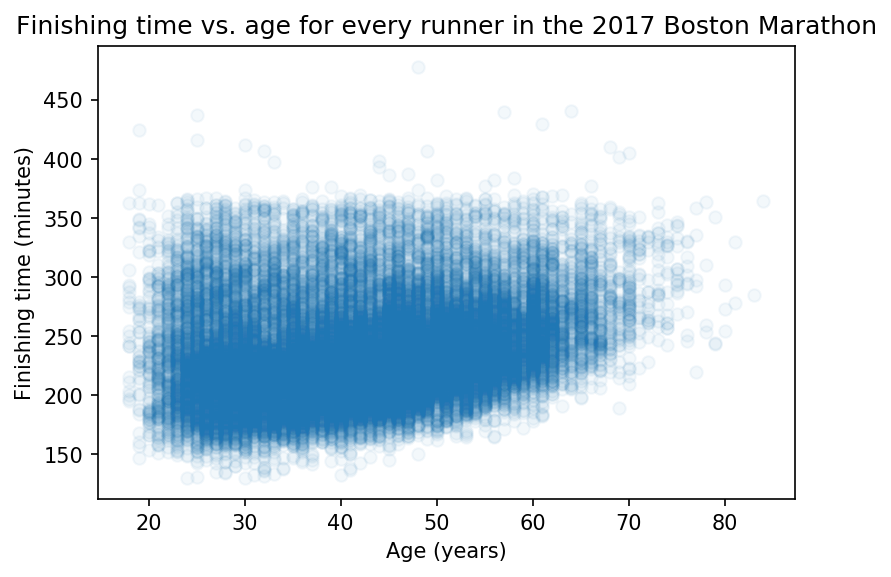

In [30]:
plt.figure(num=None, figsize=(6, 4), dpi=150, facecolor='w', edgecolor='k')
plt.scatter(age_time["Age"], age_time["Mins"], alpha=0.05)
plt.title("Finishing time vs. age for every runner in the 2017 Boston Marathon")
plt.ylabel("Finishing time (minutes)")
plt.xlabel("Age (years)")
plt.show()

The data here has too much intra-class variation to be interesting to model. Let's analyze the class means instead.

In [36]:
#Too messy, let's simplify...

df_mean_times = age_time.groupby('Age').agg({"Age":"mean", 'Mins':'mean'})
df_mean_times["Standard_Deviations"] = age_time.groupby('Age').agg({"Mins":"std"})
df_mean_times.head()

,Age,Mins,Standard_Deviations
Age,,,
18,18,258.100000,46.876446
19,19,253.846899,63.561635
20,20,237.564859,50.443204
21,21,229.729932,43.759646
22,22,236.613889,45.252558


### Here are the means alongside their standard deviations. 

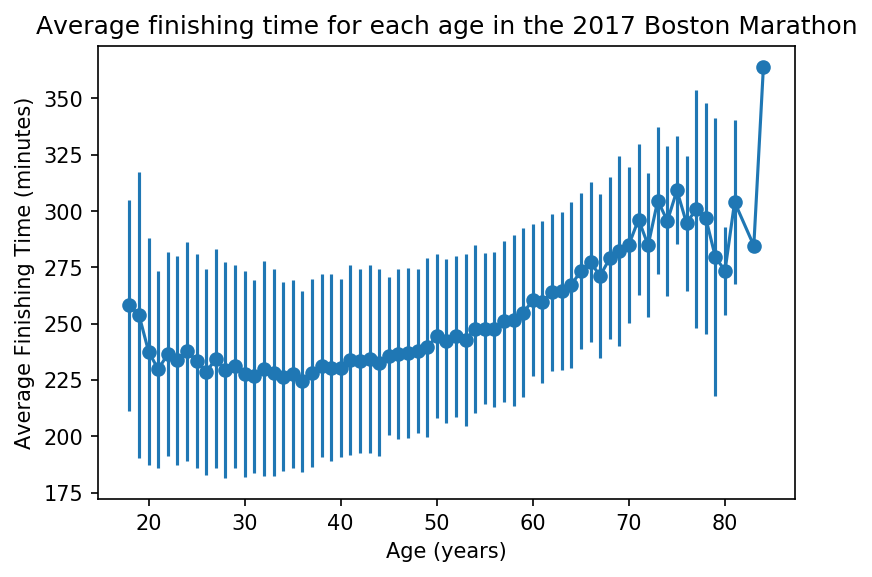

In [37]:
plt.figure(num=None, figsize=(6, 4), dpi=150, facecolor='w', edgecolor='k')
plt.scatter(df_mean_times["Age"], df_mean_times["Mins"])
plt.errorbar(df_mean_times["Age"], df_mean_times["Mins"], yerr=df_mean_times["Standard_Deviations"])
plt.title("Average finishing time for each age in the 2017 Boston Marathon")
plt.xlabel("Age (years)")
plt.ylabel("Average Finishing Time (minutes)")
plt.show()

## Let's fit some polynomial models to the data!
And compare the root mean squared errors of their fit with the data

In [38]:
from sklearn.metrics import mean_squared_error

deg = 3
deg2 = 50
deg3 = 1

x = df_mean_times["Age"]
y = df_mean_times["Mins"]
p_low = np.poly1d(np.polyfit(x, y, deg))
p_high = np.poly1d(np.polyfit(x, y, deg2))
p_line = np.poly1d(np.polyfit(x, y, deg3))


#Compute the squared error
rmse_low_order = np.sqrt(mean_squared_error(y, p_low(x)))
rmse_high_order = np.sqrt(mean_squared_error(y, p_high(x)))
rmse_line = np.sqrt(mean_squared_error(y, p_line(x)))

print("Root mean squared error of line (order 1 polynomial): ", rmse_line)
print("Root mean squared error of low order polynomial: ", rmse_low_order)
print("Root mean squared error of high order polynomial: ", rmse_high_order)

('Root mean squared error of line (order 1 polynomial): ', 15.465698916151144)
('Root mean squared error of low order polynomial: ', 9.5911128784609705)
('Root mean squared error of high order polynomial: ', 2.7255554056628251)


/Users/Larry/Code/py2env/larry/lib/python2.7/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.


### The high order polynomial has a better fit!
### Let's try looking at the fit errors of a whole range of polynomials

In [39]:
import warnings

#Do the above validation for lots of polynmoial values and plot them
poly_degrees = []
error = []
for deg in range(1, len(df_mean_times["Age"])):
    poly_degrees.append(deg)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        z = np.polyfit(x, y, deg)
    p_temp = np.poly1d(z)

    #Compute the squared error
    mse_train = np.sqrt(mean_squared_error(y, p_temp(x)))
    error.append(mse_train)

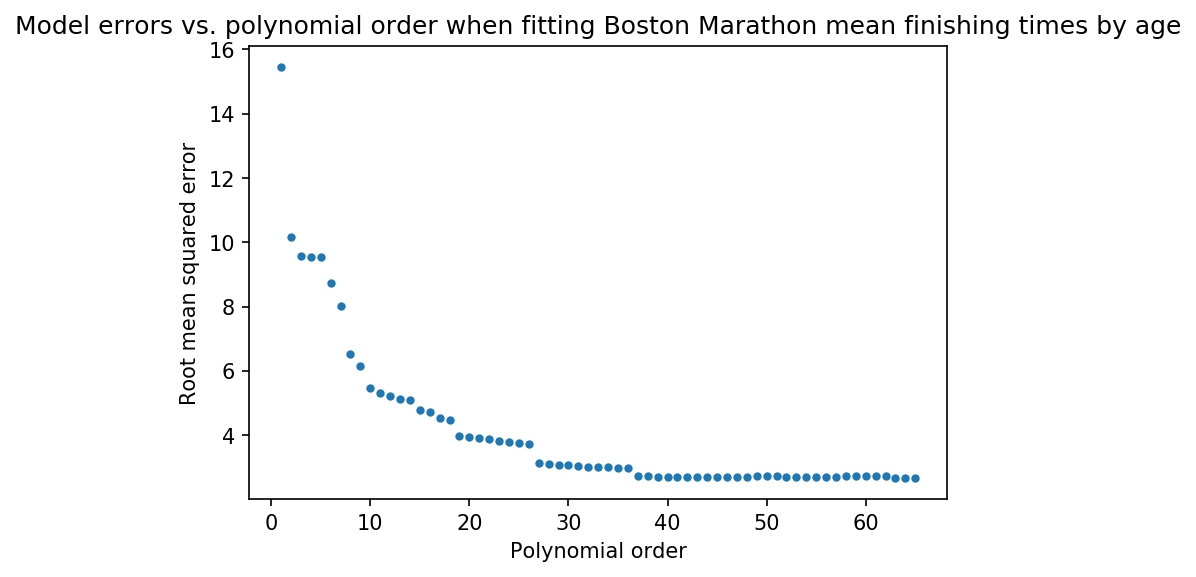

In [40]:
plt.figure(num=None, figsize=(6, 4), dpi=150, facecolor='w', edgecolor='k')
ax = plt.gca()
#ax.set_yscale("log", nonposy='clip')

plt.plot(poly_degrees, error, '.')
#plt.ylim(200,400)
plt.title("Model errors vs. polynomial order when fitting Boston Marathon mean finishing times by age")
plt.xlabel("Polynomial order")
plt.ylabel("Root mean squared error")
#plt.plot(x, y, '.', x, xp(x), '-')
plt.show()

## From this plot it looks like higher order polynomials always perform better (they have lower error!)

### But is the higher order polynomial really doing better?

### Let's check by plotting the model against the data

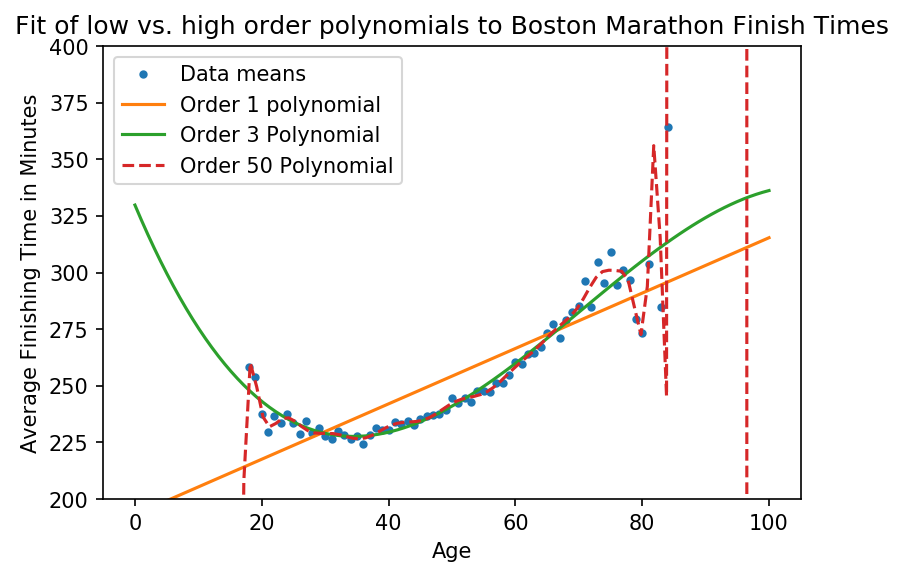

In [41]:
xp = np.linspace(0, 100, 100)

plt.figure(num=None, figsize=(6, 4), dpi=150, facecolor='w', edgecolor='k')
plt.plot(x, y, '.', label = "Data means")
plt.plot(xp, p_line(xp), '-', label="Order 1 polynomial")
plt.plot(xp, p_low(xp), '-', label="Order " + str(3) + " Polynomial")
plt.plot(xp, p_high(xp), '--', label="Order " + str(50) + " Polynomial")
plt.ylim(200,400)
plt.title("Fit of low vs. high order polynomials to Boston Marathon Finish Times")
plt.xlabel("Age")
plt.ylabel("Average Finishing Time in Minutes")
pylab.legend(loc='upper left')
#plt.plot(x, y, '.', x, xp(x), '-')
plt.show()

## The order 50 polynomial doesn't look as good as the error score suggested...
### Let's try using this model to predict the average time for other ages

In [42]:
age = 16
print("Predicted finishing time by low order polynomial for age ", age, " : ", p_low(age))
print("Predicted finishing time by high order polynomial for age ", age, " : ", p_high(age))

('Predicted finishing time by low order polynomial for age ', 16, ' : ', 253.71785560146427)
('Predicted finishing time by high order polynomial for age ', 16, ' : ', -165.16494623199105)


## The high order polynomial doesn't seem to make very good predictions...

## How can we fix this?
First let's find a better way to characterize the problem

#### Data can be understood as a sample from a population 

#### The goal of a model is to be able to predict any future data drawn from this same population

# Learning vs. optimization

This idea extends to all models and model classes.
There is a fundamental relationship between model complexity and the amount of data required to properly constrain it

Fit and generalization. Internal and external validity.

Training and validation sets

In [43]:
#Let's take a subset of the data
train_percentage = .8

train_set_size = int(len(df_mean_times["Age"]) * train_percentage)
train_ages = np.random.choice(df_mean_times["Age"], size=train_set_size, replace=False)
train_ages.sort()
valid_ages = [x for x in df_mean_times["Age"] if x not in train_ages]
train_set = df_mean_times.loc[train_ages]
valid_set = df_mean_times.loc[valid_ages]

In [44]:
deg = 3
deg2 = 70

x = train_set["Age"]
y = train_set["Mins"]
z = np.polyfit(x, y, deg)
p = np.poly1d(z)
p_high = np.poly1d(np.polyfit(x, y, deg2))

#Compute the squared error on the training set
rmse_low_order = np.sqrt(mean_squared_error(y, p(x)))
rmse_high_order = np.sqrt(mean_squared_error(y, p_high(x)))
print("Root mean squared error of low order polynomial TRAIN: ", rmse_low_order)
print("Root mean squared error of high order polynomial TRAIN: ", rmse_high_order)

#Compute the squared error on the validation set
x_valid = valid_set["Age"]
y_valid = valid_set["Mins"]
rmse_low_order = np.sqrt(mean_squared_error(y_valid, p(x_valid)))
rmse_high_order = np.sqrt(mean_squared_error(y_valid, p_high(x_valid)))
print("Root mean squared error of low order polynomial VALID: ", rmse_low_order)
print("Root mean squared error of high order polynomial VALID: ", rmse_high_order)

('Root mean squared error of low order polynomial TRAIN: ', 10.498845814871146)
('Root mean squared error of high order polynomial TRAIN: ', 1.6995513654385062)
('Root mean squared error of low order polynomial VALID: ', 5.0184010125300826)
('Root mean squared error of high order polynomial VALID: ', 3136.8876531107271)


/Users/Larry/Code/py2env/larry/lib/python2.7/site-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


In [45]:
import warnings

#Do the above validation for lots of polynmoial values and plot them
poly_degrees = []
train_error = []
valid_error = []
for deg in range(1, len(df_mean_times["Age"])):
    poly_degrees.append(deg)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        z = np.polyfit(x, y, deg)
    p = np.poly1d(z)

    #Compute the squared error on the training set
    mse_train = np.sqrt(mean_squared_error(y, p(x)))
    train_error.append(mse_train)
    #Compute the squared error on the validation set
    mse_valid = np.sqrt(mean_squared_error(y_valid, p(x_valid)))
    valid_error.append(mse_valid)



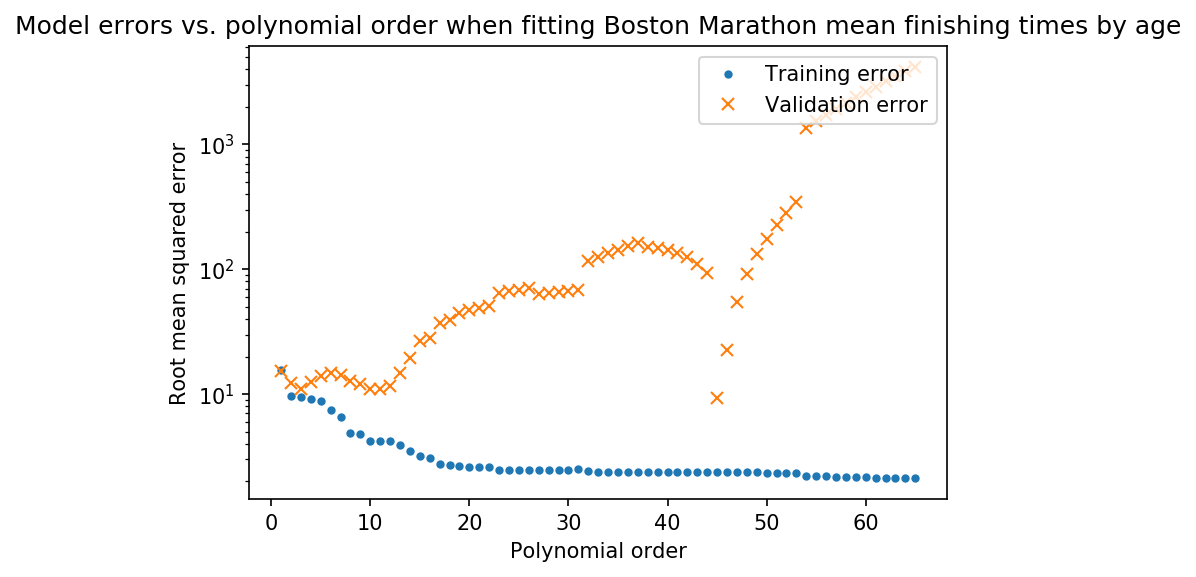

In [42]:
plt.figure(num=None, figsize=(6, 4), dpi=150, facecolor='w', edgecolor='k')
ax = plt.gca()
ax.set_yscale("log", nonposy='clip')

plt.plot(poly_degrees, train_error, '.', label="Training error")
plt.plot(poly_degrees, valid_error, 'x', label="Validation error")
#plt.ylim(200,400)
plt.title("Model errors vs. polynomial order when fitting Boston Marathon mean finishing times by age")
plt.xlabel("Polynomial order")
plt.ylabel("Root mean squared error")
pylab.legend(loc='upper right')

#plt.plot(x, y, '.', x, xp(x), '-')
plt.show()

## Let's zoom in on the first few polynomial orders

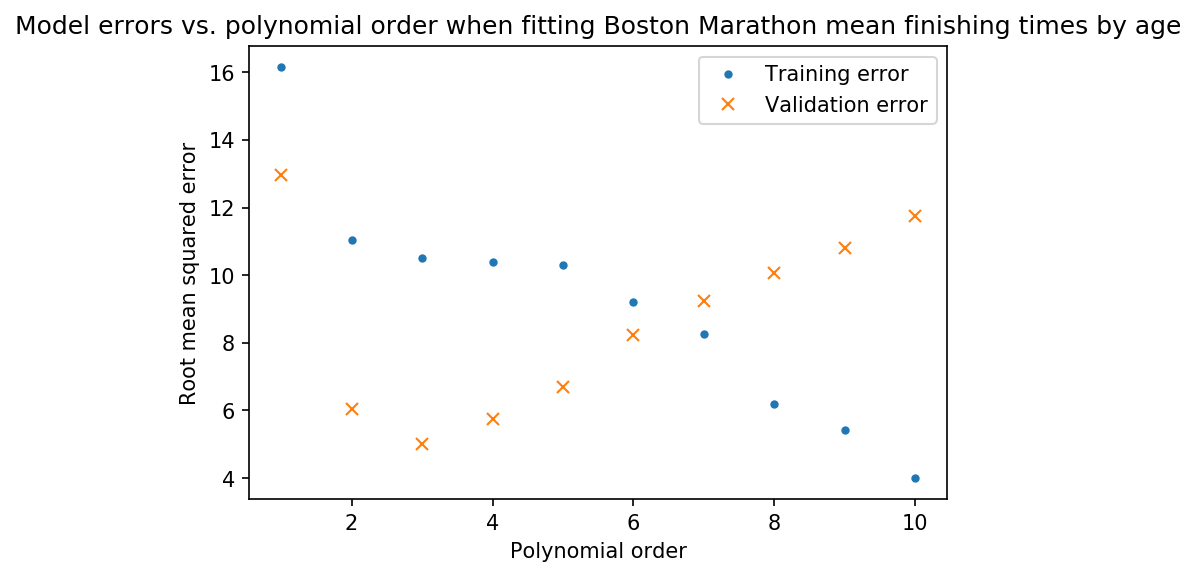

In [46]:
num_points = 10
plt.figure(num=None, figsize=(6, 4), dpi=150, facecolor='w', edgecolor='k')
ax = plt.gca()

plt.title("Model errors vs. polynomial order when fitting Boston Marathon mean finishing times by age")

plt.plot(poly_degrees[:num_points], train_error[:num_points], '.', label="Training error")
plt.plot(poly_degrees[:num_points], valid_error[:num_points], 'x', label="Validation error")
#plt.ylim(200,400)
pylab.legend(loc='upper right')

plt.xlabel("Polynomial order")
plt.ylabel("Root mean squared error")
#plt.plot(x, y, '.', x, xp(x), '-')
plt.show()

In [47]:
best_val_error = poly_degrees[valid_error.index(min(valid_error))]
print("The polynomial of degree ", best_val_error, " has the best valid error. RMSE = ", min(valid_error))

('The polynomial of degree ', 3, ' has the best valid error. RMSE = ', 5.0184010125300826)


## But it's not that simple. It's possible to overfit your validation set too...

In [ ]:
#Illustrate pushing the capacity of the validation set. Use this to motivate the idea of cross-validation

In [58]:
# Train on almost all the data
train_percentage = .98

train_set_size = int(len(df_mean_times["Age"]) * train_percentage)

In [59]:
deg = 5

valid_scores = []
for i in range(100):
    #Get a new training set
    train_ages = np.random.choice(df_mean_times["Age"], size=train_set_size, replace=False)
    train_ages.sort()
    valid_ages = [x for x in df_mean_times["Age"] if x not in train_ages]
    train_set = df_mean_times.loc[train_ages]
    valid_set = df_mean_times.loc[valid_ages]

    x = train_set["Age"]
    y = train_set["Mins"]
    z = np.polyfit(x, y, deg)
    p = np.poly1d(z)

    #Compute the squared error on the validation set
    x_valid = valid_set["Age"]
    y_valid = valid_set["Mins"]
    rmse = np.sqrt(mean_squared_error(y_valid, p(x_valid)))
    valid_scores.append(rmse)
    
print("The standard deviation of the validation process for a val set of size ", len(valid_set), "is", 
      np.std(valid_scores))


('The standard deviation of the validation process for a val set of size ', 2, 'is', 12.725708199878204)


## Now let's do this for lots of different validation set sizes and look at the trade-off between train error and test error as we change the split

In [65]:
deg = 5

samples_per_split = 200
num_splits_to_test = 40

def compute_train_and_test_errors(poly_degree, train_percentage):
    train_set_size = int(len(df_mean_times["Age"]) * train_percentage)

    train_scores = []
    valid_scores = []
    for i in range(samples_per_split):
        #Get a new training set
        train_ages = np.random.choice(df_mean_times["Age"], size=train_set_size, replace=False)
        train_ages.sort()
        valid_ages = [x for x in df_mean_times["Age"] if x not in train_ages]
        train_set = df_mean_times.loc[train_ages]
        valid_set = df_mean_times.loc[valid_ages]

        x = train_set["Age"]
        y = train_set["Mins"]
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)

        #Compute the squared error on the train set
        rmse_train = np.sqrt(mean_squared_error(y, p(x)))
        train_scores.append(rmse_train)

        #Compute the squared error on the validation set
        x_valid = valid_set["Age"]
        y_valid = valid_set["Mins"]
        rmse_valid = np.sqrt(mean_squared_error(y_valid, p(x_valid)))
        valid_scores.append(rmse_valid)
        
    train_std = np.std(train_scores)
    valid_std = np.std(valid_scores)
    train_mean = np.mean(train_scores)
    valid_mean = np.mean(valid_scores)

    return (train_std, valid_std, train_mean, valid_mean)

train_percentages = []
train_stds = []
valid_stds = []
train_means = []
valid_means = []
for i in range(int(num_splits_to_test/2), num_splits_to_test-1):
    train_percentage = i/num_splits_to_test
    train_percentages.append(train_percentage)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_std, valid_std, train_mean, valid_mean = compute_train_and_test_errors(deg, train_percentage)
    train_stds.append(train_std)
    valid_stds.append(valid_std)
    train_means.append(train_mean)
    valid_means.append(valid_mean)

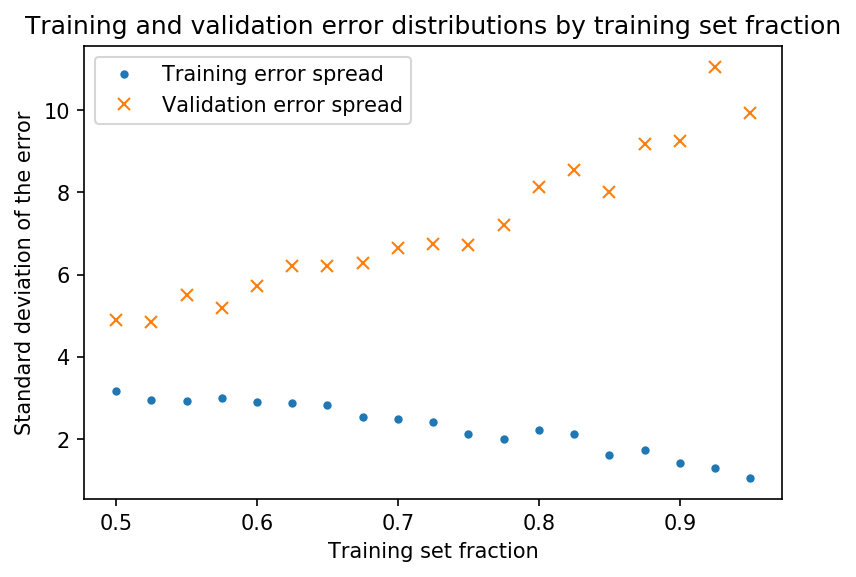

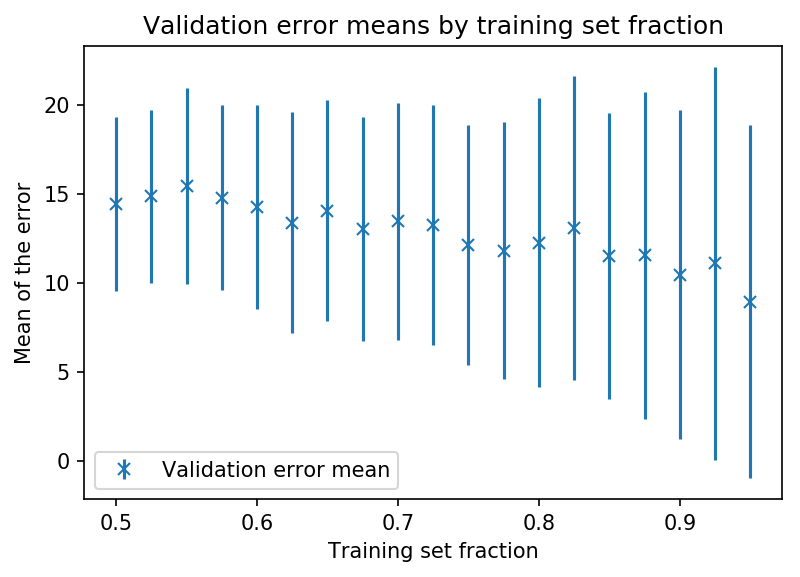

In [66]:
#Now plot the train_percentages, train_stds, and valid_stds
plt.figure(num=None, figsize=(6, 4), dpi=150, facecolor='w', edgecolor='k')
ax = plt.gca()
#ax.set_yscale("log", nonposy='clip')

plt.title("Training and validation error distributions by training set fraction")

plt.plot(train_percentages, train_stds, '.', label='Training error spread')
plt.plot(train_percentages, valid_stds, 'x', label='Validation error spread')
#plt.ylim(200,400)
plt.ylabel("Standard deviation of the error")
plt.xlabel("Training set fraction")
#plt.plot(x, y, '.', x, xp(x), '-')
pylab.legend(loc='upper left')

plt.show()

#Now plot the train_percentages, train_means, and valid_means
plt.figure(num=None, figsize=(6, 4), dpi=150, facecolor='w', edgecolor='k')
ax = plt.gca()
#ax.set_yscale("log", nonposy='clip')

plt.title("Validation error means by training set fraction")

#plt.errorbar(train_percentages, train_means, yerr=train_stds, fmt='.', label='Training error mean')
plt.errorbar(train_percentages, valid_means, yerr=valid_stds, fmt='x', label='Validation error mean')
#plt.plot(train_percentages, train_means, '.', label='Training error mean')
#plt.plot(train_percentages, valid_means, 'x', label='Validation error mean')
#plt.ylim(200,400)
plt.ylabel("Mean of the error")
plt.xlabel("Training set fraction")
#plt.plot(x, y, '.', x, xp(x), '-')
pylab.legend(loc='lower left')

plt.show()

In [ ]:
#Takeaway from above: Use a large enough validation set!!!
#But not so large that the trained models are no longer effective...

In [ ]:
#What if you don't have enough data for a large validation set?

#I've already hinted at the answer! Make use of sampling and statistics!!!

In [67]:
#Cross-validation
#Instead of using a single validation set, use multiple validation sets and take the mean!

deg = 5
train_percentage = .9 

resamples_cross_val = 10

train_set_size = int(len(df_mean_times["Age"]) * train_percentage)
cross_val_means = []
single_valid_STDs = []
for k in range(resamples_cross_val):
    valid_scores = []
    for i in range(100):
        #Get a new training set
        train_ages = np.random.choice(df_mean_times["Age"], size=train_set_size, replace=False)
        train_ages.sort()
        valid_ages = [x for x in df_mean_times["Age"] if x not in train_ages]
        train_set = df_mean_times.loc[train_ages]
        valid_set = df_mean_times.loc[valid_ages]

        x = train_set["Age"]
        y = train_set["Mins"]
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)

        #Compute the squared error on the validation set
        x_valid = valid_set["Age"]
        y_valid = valid_set["Mins"]
        rmse = np.sqrt(mean_squared_error(y_valid, p(x_valid)))
        valid_scores.append(rmse)
    cross_val_means.append(np.mean(valid_scores))
    single_valid_STDs.append(np.std(valid_scores))

single_valid_STD_mean = np.mean(single_valid_STDs)
cross_validation_STD = np.std(cross_val_means)

print("Standard deviation of single validations: ", single_valid_STD_mean) #This is robustly estimated by repeating it and averaging the std
print("Standard deviation of cross validation: ", cross_validation_STD)

('Standard deviation of single validations: ', 10.069681284359827)
('Standard deviation of cross validation: ', 0.58525080627043302)


## Cross validation is more robust!!

It's also more computationally intensive (i.e. slower)

## The above is cross-validation by resampling (specifically bootstrapping)

## Other popular schemes for cross-validation include n-fold cross validation and leave one out cross validation

n-fold cross validation is when you split your data into n parts and perform cross validation n times with each of the n parts acting as the validation set once (where the remainder of the data is used to train the model.)

![5-fold cross val image](https://i.stack.imgur.com/YWgro.gif "5-fold cross validation")

Leave one out cross validation involves training the model on all of the data except one data point, validating the model on that removed data point, and repeating for all data points. This is equivalent to n-fold cross validation in the special case where n = the number of data points in your dataset.

![leave one out cross val image](https://www.researchgate.net/profile/Christophe_Rabut/publication/259519308/figure/fig7/AS:297309117140994@1447895425090/Figure-8-Leave-one-out-cross-validation-procedure.png "Leave one out cross validation")

Leave one out cross validation can also be generalized to leave p out cross validation.

# Model validation procedures are essential for proper data science!










(With one small exception)

